In [1]:
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, confusion_matrix, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.tree import DecisionTreeRegressor

In [2]:
%matplotlib inline

# GPU Kepler architecture

![alt text](kepler.jpeg "Title")

http://archive.ics.uci.edu/ml/datasets/SGEMM+GPU+kernel+performance

# Загружаем Dataset

In [3]:
sample = pd.read_csv('./sgemm_product_dataset/sgemm_product.csv', sep=',')

This data set measures the running time of a matrix-matrix product A\*B = C, where all matrices have size 2048 x 2048, using a parameterizable SGEMM __GPU__ kernel with 241600 possible parameter combinations. For each tested combination, 4 runs were performed and their results are reported as the 4 last columns. All times are measured in milliseconds*. 


Independent variables:
- 1-2: MWG, NWG: per-matrix 2D tiling at workgroup level: {16, 32, 64, 128} (integer)
- 3: KWG: inner dimension of 2D tiling at workgroup level: {16, 32} (integer)
- 4-5: MDIMC, NDIMC: local workgroup size: {8, 16, 32} (integer)
- 6-7: MDIMA, NDIMB: local memory shape: {8, 16, 32} (integer)
- 8 KWI: kernel loop unrolling factor: {2, 8} (integer)
- 9-10: VWM, VWN: per-matrix vector widths for loading and storing: {1, 2, 4, 8} (integer)
- 11-12: STRM, STRN: enable stride for accessing off-chip memory within a single thread: {0, 1} (categorical)
- 13-14: SA, SB: per-matrix manual caching of the 2D workgroup tile: {0, 1} (categorical)


Output:

15-18. Run1, Run2, Run3, Run4: performance times in milliseconds for 4 independent runs using the same parameters. They range between 13.25 and 3397.08.

In [4]:
sample.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,Run1 (ms),Run2 (ms),Run3 (ms),Run4 (ms)
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,115.26,115.87,118.55,115.80
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,78.13,78.25,79.25,79.19
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,79.84,80.69,80.76,80.97
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,84.32,89.90,86.75,85.58
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,115.13,121.98,122.73,114.81


# Целевая переменная

In [5]:
y = sample['Run1 (ms)'].values

In [6]:
# y = (sample['Run1 (ms)'] + sample['Run2 (ms)'] + sample['Run3 (ms)'] + sample['Run4 (ms)'])/4.0

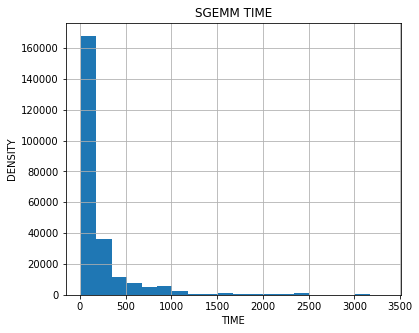

In [7]:
plt.figure(figsize=(6,5))
plt.hist(y, bins=20)
plt.grid()
plt.title('SGEMM TIME')
plt.xlabel('TIME')
plt.ylabel('DENSITY')
plt.show()

# Признаки

In [8]:
# вместо 3 признаков используй все колонки
# теперь посмотрим как изменился r2 score
# стало значительно лучше - диаграмки стали нагляднее - отделили плохие от хороших, но отрицательное время все равно осталось
# если взять только положительные значения - модель улучшиться
X = sample[["NWG","NWG","KWG"]].values

![alt text](minmax.png "Title")

In [9]:
X_proc = minmax_scale(X=X)

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, DataConversionWarning)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_proc, y, test_size=0.33, random_state=7)

# Выбор модели

In [11]:
model = LinearRegression()

In [12]:
# Ridge
# model = Ridge(alpha=10.5) - можно попробовать взять такую модель - но сильно результат не улучшиться

In [13]:
# DecisionTreeRegressor
# решающие деревья тоже могут выпонять задачу регрессии
# model = DecisionTreeRegressor()
# тут хорошо работает - мы смогли определить сколько будут длиться задача перемножения матриц для разных параметров

In [14]:
model.fit(X=X_train, y=y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

# Анализ тестовой выборки

In [15]:
def regression_report(t, p, fn):
    def rank_transform(vec, nbins=10):
        step = 100.0 / nbins
        bins = np.percentile(vec, np.linspace(step, 100.0 - step, nbins - 1))
        rvec = np.zeros(vec.shape)
        for b in bins:
            rvec[vec >= b] += 1
        return rvec
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    ax0, ax1 = axes
    ax0.hist(p, bins=50, color='blue', histtype='bar', normed=True)
    ax0.set_title('Histogram', fontsize=14)
    ax0.set_ylabel('DENSITY', fontsize=14)
    ax0.set_xlabel('PREDICTED', fontsize=14)
    cm = confusion_matrix(rank_transform(t, nbins=10), rank_transform(p, nbins=10))
    cm = cm.astype(np.float) / cm.sum(axis=1)[:,np.newaxis]
    cm_plot = ax1.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
    ax1.set_title('Confusion Matrix', fontsize=14)
    ax1.set_ylabel('TRUE', fontsize=14)
    ax1.set_xlabel('PREDICTED', fontsize=14)
    fig.colorbar(cm_plot, ax=ax1)
    plt.tight_layout()
    plt.savefig(fn, dpi=300)

In [16]:
y_pred = model.predict(X_test)

In [17]:
r2_score(y_pred=y_pred, y_true=y_test)

0.10102507543870154

In [18]:
mean_absolute_error(y_pred=y_pred, y_true=y_test)

198.60370946938684

In [19]:
mean_squared_error(y_pred=y_pred, y_true=y_test)

122456.85244529316

/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


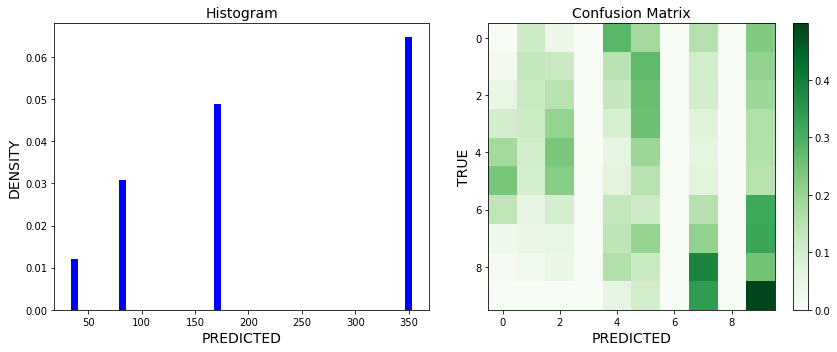

In [20]:
regression_report(t=y_test, p=y_pred, fn='sgemm_cv.png')

# Задание:
* Обосновать выбор оптимальной модели для решение текущей задачи (используя метрики качества).
* Какие параметры данной модели являются оптимальными?